In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Model from scratch

## ✧ The Big Picture
* **Get the dataset (pairs of inputs & labels)**
* **`Forward Pass` : input ➡️ function(model) ➡️ output(prediction)** 
* **`Compute the Loss` : predictions - labels**
* **`Backward Pass` : i.e Backpropagation**
* **`Update the parameters` : i.e Weights & Biases**

# MNIST data setup

**`dataset.py`**

In [2]:
from pathlib import Path # Import the Path class from pathlib module
import requests # Import the requests module for making HTTP requests

def myData():
    ### Download Dataset ###
    data_path = Path("data") # Create a Path object for the data directory
    actual_path = data_path/"mnist" # Create a Path object for the mnist subdirectory

    # Create the directory if it does not exist
    actual_path.mkdir(parents=True, exist_ok=True)

    url = "https://github.com/pytorch/tutorials/raw/main/_static/" # The base URL for the dataset
    file_name = "mnist.pkl.gz" # The file name of the dataset

    # Check if the file already exists in the local directory
    if not (actual_path/file_name).exists():
        # If not, download the file from the URL and save it to the local directory
        content = requests.get(url+file_name).content # Get the content of the file as bytes
        (actual_path/file_name).open("wb").write(content) # Open the file in write mode and write the content

    ### Extract Dataset ###
    import pickle # Import the pickle module for loading and saving Python objects
    import gzip # Import the gzip module for working with compressed files

    # Open the compressed file in read mode
    with gzip.open((actual_path/file_name).as_posix(), "rb") as f:
        # Load the pickle object from the file, which contains three tuples: 
        # (x_train,y_train), (x_valid,y_valid), (x_test,y_test)
        ((x_train,y_train),(x_valid,y_valid),_) = pickle.load(file=f, encoding="latin-1")
        # We only need the first two tuples, so we ignore the third one with an underscore

    return (x_train,y_train), (x_valid,y_valid) # Return the two tuples as the output of the function


In [3]:
(x_train,y_train), (x_valid,y_valid) = myData()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

x_train shape: (50000, 784), y_train shape: (50000,)
x_valid shape: (10000, 784), y_valid shape: (10000,)


In [4]:
! tree /kaggle
! ls -sh /kaggle/working/data/mnist/

/kaggle
├── input
├── lib
│   └── kaggle
│       └── gcp.py
├── src
│   └── script.ipynb
└── working
    ├── __notebook__.ipynb
    └── data
        └── mnist
            └── mnist.pkl.gz

7 directories, 4 files
total 16M
16M mnist.pkl.gz


## Data Exploration
Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

**`data_exploration.py`**

You have to reshape the **x_train[0]** array to **(28, 28)** because the **imshow()** function expects a 2D array as input for displaying a grayscale image. The x_train[0] array is a 1D array of length 784, which represents a **flattened image of 28 by 28 pixels**. By reshaping it to (28, 28), **you are restoring the original shape of the image and making it compatible with imshow().**

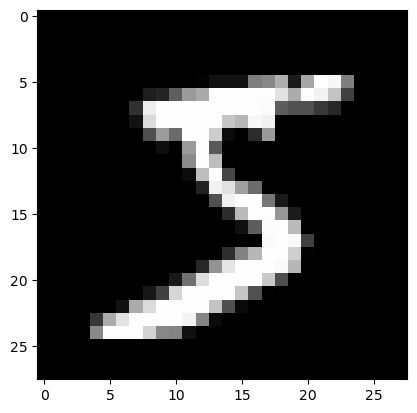

(50000, 784)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.show()

print(x_train.shape)

## Forward Pass
1. **initialize weights and biases (i.e parameters).**
2. **NN architecture : input ➡️ output (simple architecture with no hidden layer)**
     * **Number of neurons in the Input Layer is (28x28) = 784 and**
     * **Number of neurons in the Output Layer is 10**

**`model.py`**

In [6]:
import torch

In [7]:
# Convert the numpy arrays to tensor
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
x_train, y_train, x_valid, y_valid

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([3, 8, 6,  ..., 5, 6, 8]))

1. **initialize weights and biases (i.e parameters).**

**`Xavier Initialization`** is a technique for initializing the weights of a neural network in a way that **preserves the variance of the inputs and outputs of each layer**. The idea is **to avoid having very small or very large values in the weights,** which **can cause vanishing or exploding gradients during training.** Xavier initialization draws the weights from a uniform distribution with a specific range, depending on the number of input and output units of each layer.

In [8]:
import math
torch.manual_seed(0)
weights = torch.randn(784,10,requires_grad=True) / math.sqrt(784) # Xavier Initialization
bias = torch.zeros(10,requires_grad=True) 

2. **NN architecture : input ➡️ output (simple architecture with no hidden layer)**

In [9]:
def model(batched_input):
    return batched_input @ weights + bias

3. **Loss Function**

In [10]:
# softmax activation function
def softmax(x):
    return x.exp()/x.exp().sum(-1).unsqueeze(-1)

print(softmax(model(x_train)))
print()
print(softmax(model(x_train)).shape)

tensor([[0.0536, 0.0503, 0.0946,  ..., 0.1342, 0.0897, 0.1038],
        [0.0529, 0.0615, 0.1341,  ..., 0.1225, 0.0830, 0.0774],
        [0.0952, 0.1340, 0.1113,  ..., 0.1033, 0.0914, 0.0916],
        ...,
        [0.0671, 0.1293, 0.0686,  ..., 0.1668, 0.1060, 0.0906],
        [0.0626, 0.1156, 0.0831,  ..., 0.1021, 0.0638, 0.1103],
        [0.0542, 0.0950, 0.0795,  ..., 0.1658, 0.0540, 0.1028]],
       grad_fn=<DivBackward0>)

torch.Size([50000, 10])


In [11]:
# Cross Entropy Loss
def cross_entropy_loss(preds, targets):
    batch_size, output_features = preds.shape
    one_hot_encode_targets = torch.eye(output_features)[targets]
    # -1/n sum p * log(q) -> n is batch_size : sum everything and take average over the batch
    return -(one_hot_encode_targets * softmax(preds).log()).sum()/batch_size

loss_function = cross_entropy_loss

Test if our implementation of `cross_entropy_loss` is correct or not.

In [12]:
import torch.nn.functional as F

batch_size = 64

batched_x = x_train[:batch_size]
preds = model(batched_x)
batched_y = y_train[:batch_size]

print(f"PyTorch's Function: {F.cross_entropy(preds, batched_y)}")
print(f"My Function: {cross_entropy_loss(preds, batched_y)}")

PyTorch's Function: 2.4608449935913086
My Function: 2.4608447551727295


In [13]:
# Accuracy
def accuracy_function(preds, targets):
    preds_class = torch.argmax(preds, dim = 1)
    return (preds_class == targets).float().mean()

## Training

In [14]:
# epochs = 2
# lr = 0.5
# n = x_train.shape[0] # (50000, 784)
# batch_size = 64
# number_of_batches = n // batch_size + 1

# for epoch in range(epochs):
#     for i in range(number_of_batches):
#         start_idx = i * batch_size
#         end_idx = (i + 1) * batch_size
#         xb = x_train[start_idx:end_idx]
#         yb = y_train[start_idx:end_idx]
#         preds = model(xb)
#         loss = loss_function(preds, yb)
#         accuracy = accuracy_function(preds, yb)
#         loss.backward() # PyTorch autograd
        
#         with torch.no_grad(): # temporarily sets all of the requires_grad flags to false; reduces memory consumption
#             # update parameters (gradients/slope)
#             weights.data -= weights.grad * lr
#             bias.data -= bias.grad * lr
            
#             # reset the gradient
#             weights.grad.zero_()
#             bias.grad.zero_()
            
#             # logging
#             if i % 100 == 0:
#                 train_loss, train_accuracy = loss.item(), accuracy.item() * 100
#                 print(f"Loss: {train_loss:6f} ... Accuracy: {train_accuracy:0.1f}%")

# Model with PyTorch
## ✧ The Big Picture
* **Dataset (Training/Validation/Test)**
* **Build the Model**
* **Define Loss Function & Optimizer**
* **Define Trainer (Predictions ➡️ Compute Loss(Label - Predictions) ➡️ Backpropagation)**
* **Define Test (on Validation set)**
* **Run the Trainer & Test**

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [16]:
!tree /kaggle

/kaggle
├── input
├── lib
│   └── kaggle
│       └── gcp.py
├── src
│   └── script.ipynb
└── working
    ├── __notebook__.ipynb
    └── data
        └── mnist
            └── mnist.pkl.gz

7 directories, 4 files


## Dataset

In [17]:
training_ds = MNIST(root="data",train=True,download=True,transform = T.ToTensor())
validation_ds = MNIST(root="data",train=False,download=True,transform = T.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 82702184.22it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39088639.50it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24119873.74it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5141843.12it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [18]:
!tree /kaggle

/kaggle
├── input
├── lib
│   └── kaggle
│       └── gcp.py
├── src
│   └── script.ipynb
└── working
    ├── __notebook__.ipynb
    └── data
        ├── MNIST
        │   └── raw
        │       ├── t10k-images-idx3-ubyte
        │       ├── t10k-images-idx3-ubyte.gz
        │       ├── t10k-labels-idx1-ubyte
        │       ├── t10k-labels-idx1-ubyte.gz
        │       ├── train-images-idx3-ubyte
        │       ├── train-images-idx3-ubyte.gz
        │       ├── train-labels-idx1-ubyte
        │       └── train-labels-idx1-ubyte.gz
        └── mnist
            └── mnist.pkl.gz

9 directories, 12 files


Image shape: torch.Size([1, 28, 28])
Label: 5


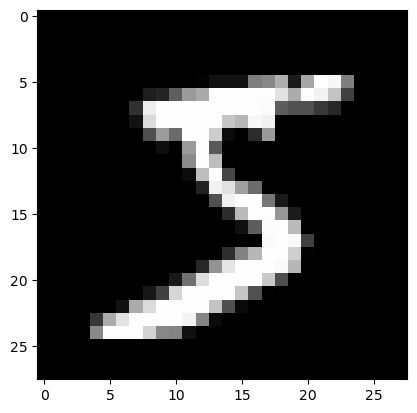

In [19]:
image, label = training_ds[0]
print(f"Image shape: {image.shape}")
print(f"Label: {label}")
plt.imshow(image.float().reshape(28,28), cmap="gray")

* Create DataLoader: it makes easy to iterate over batches

In [20]:
# train_ds => (image, label) pair
train_dl = DataLoader(dataset=training_ds,batch_size=64, shuffle=True)
valid_dl = DataLoader(dataset=validation_ds,batch_size=64, shuffle=True)

# explore train_ds
for image, label in train_dl:
    print("train_ds")
    print(image.shape)
    print(f"Flatten: {image.flatten(1,-1).shape}")
    print(f"No. of Labels: {len(label)}")
    print(label)
    print()
    break

# explore valid_ds
for image, label in valid_dl:
    print("valid_ds")
    print(image.shape)
    print(f"No. of Labels: {len(label)}")
    print(label)
    break

train_ds
torch.Size([64, 1, 28, 28])
Flatten: torch.Size([64, 784])
No. of Labels: 64
tensor([4, 5, 0, 8, 3, 4, 1, 6, 5, 4, 1, 8, 3, 7, 5, 3, 2, 6, 0, 6, 6, 7, 1, 4,
        9, 1, 0, 4, 6, 0, 5, 2, 2, 8, 1, 5, 1, 0, 2, 1, 8, 5, 4, 7, 7, 3, 7, 9,
        8, 9, 2, 9, 1, 1, 1, 9, 7, 5, 3, 6, 5, 5, 4, 4])

valid_ds
torch.Size([64, 1, 28, 28])
No. of Labels: 64
tensor([6, 8, 3, 6, 5, 6, 4, 6, 7, 6, 9, 5, 1, 0, 2, 2, 5, 4, 4, 8, 3, 3, 1, 5,
        1, 5, 1, 7, 8, 3, 8, 5, 9, 5, 2, 5, 6, 2, 1, 8, 0, 8, 5, 0, 0, 2, 5, 1,
        8, 3, 6, 9, 2, 0, 8, 0, 9, 0, 9, 9, 2, 6, 4, 0])


## Model Building

In [21]:
class MNISTmodel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # linear layer
        self.Linear = torch.nn.Linear(in_features= 28 * 28, out_features=10)
        
    def forward(self, batched_x):
        batched_x = batched_x.flatten(1,-1) # (bs,1,28,28) => (bs,784)
        return self.Linear(batched_x)
     
model = MNISTmodel()
print(model)
print()
print(model.parameters())

MNISTmodel(
  (Linear): Linear(in_features=784, out_features=10, bias=True)
)

<generator object Module.parameters at 0x7ef6089c82e0>


## Define Loss Function & Optimizer

In [22]:
# Loss Function
loss_function = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.5)

# accuracy function for logging
def accuracy_function(preds,yb):
    preds_class = torch.argmax(preds, dim=1)
    return (preds_class == yb).float().mean()

## Define Trainer

In [23]:
def train(dataloader, model, loss_function, optimizer):
    for batch_idx, (xb, yb) in enumerate(dataloader):
        # prediction
        preds = model(xb)
        
        # loss
        loss = loss_function(preds, yb)
        
        # backpropagation
        loss.backward()
        
        # accuracy
        accuracy = accuracy_function(preds,yb)
        
        # optimizer: updatest the parameters(weights & biases)
        optimizer.step()
        optimizer.zero_grad()
        
        # logging
        if batch_idx % 100 == 0:
            train_loss = loss.item()
            train_accuracy = accuracy.item() * 100
            print(f"Train Loss: {train_loss:6f}, Train Accuracy: {train_accuracy:0.1f}%")
            

## Define Test

In [24]:
# Define Test => Not updating any parameters (weights & biases) because we are testing
def test(dataloader, model, loss_function):
    model.eval()
    
    with torch.no_grad():
        for xb, yb in dataloader:
            preds = model(xb)
            loss = loss_function(preds, yb)
            accuracy = accuracy_function(preds, yb)
            
            # Logging
            test_loss = loss.item()
            test_accuracy = accuracy.item() * 100
        print(f"Test Loss: {test_loss:6f}, Test Accuracy: {test_accuracy:0.1f}%")

## Run the Model

In [25]:
epochs = 2

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------------")
    train(dataloader=train_dl, model = model, loss_function=loss_function, optimizer=optimizer)
    test(dataloader=valid_dl, model = model, loss_function=loss_function)
print("Finished !!!")

Epoch: 0
-------------
Train Loss: 2.362597, Train Accuracy: 7.8%
Train Loss: 0.279414, Train Accuracy: 95.3%
Train Loss: 0.498776, Train Accuracy: 79.7%
Train Loss: 0.179664, Train Accuracy: 95.3%
Train Loss: 0.226012, Train Accuracy: 95.3%
Train Loss: 0.246771, Train Accuracy: 95.3%
Train Loss: 0.348904, Train Accuracy: 92.2%
Train Loss: 0.185858, Train Accuracy: 95.3%
Train Loss: 0.456823, Train Accuracy: 89.1%
Train Loss: 0.367517, Train Accuracy: 90.6%
Test Loss: 0.223713, Test Accuracy: 93.8%
Epoch: 1
-------------
Train Loss: 0.386669, Train Accuracy: 89.1%
Train Loss: 0.345239, Train Accuracy: 89.1%
Train Loss: 0.232453, Train Accuracy: 95.3%
Train Loss: 0.103537, Train Accuracy: 96.9%
Train Loss: 0.516193, Train Accuracy: 87.5%
Train Loss: 0.462177, Train Accuracy: 82.8%
Train Loss: 0.267572, Train Accuracy: 95.3%
Train Loss: 0.107691, Train Accuracy: 95.3%
Train Loss: 0.309642, Train Accuracy: 85.9%
Train Loss: 0.152003, Train Accuracy: 93.8%
Test Loss: 0.369485, Test Accurac

## All the codes in one

In [26]:
# Import Modules
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Download Dataset
training_ds = MNIST(root="data",train=True,download=True,transform = T.ToTensor())
validation_ds = MNIST(root="data",train=False,download=True,transform = T.ToTensor())

# Create DataLoader: it makes easy to iterate over batches
train_dl = DataLoader(dataset=training_ds,batch_size=64, shuffle=True)
valid_dl = DataLoader(dataset=validation_ds,batch_size=64, shuffle=True)

# Model Building
class MNISTmodel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # linear layer
        self.Linear = torch.nn.Linear(in_features= 28 * 28, out_features=10)
        
    def forward(self, batched_x):
        batched_x = batched_x.flatten(1,-1) # (bs,1,28,28) => (bs,784)
        return self.Linear(batched_x)
     
model = MNISTmodel()
print(model)

# Define Loss Function & Optimizer
# Loss Function
loss_function = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.5)

# accuracy function for logging
def accuracy_function(preds,yb):
    preds_class = torch.argmax(preds, dim=1)
    return (preds_class == yb).float().mean()

# Trainer
def train(dataloader, model, loss_function, optimizer):
    for batch_idx, (xb, yb) in enumerate(dataloader):
        # prediction
        preds = model(xb)
        
        # loss
        loss = loss_function(preds, yb)
        
        # backpropagation
        loss.backward()
        
        # accuracy
        accuracy = accuracy_function(preds,yb)
        
        # optimizer: updatest the parameters(weights & biases)
        optimizer.step()
        optimizer.zero_grad()
        
        # logging
        if batch_idx % 100 == 0:
            train_loss = loss.item()
            train_accuracy = accuracy.item() * 100
            print(f"Train Loss: {train_loss:6f}, Train Accuracy: {train_accuracy:0.1f}%")

# Define tester
# Define Test => Not updating any parameters (weights & biases) because we are testing
def test(dataloader, model, loss_function):
    model.eval()
    
    with torch.no_grad():
        for xb, yb in dataloader:
            preds = model(xb)
            loss = loss_function(preds, yb)
            accuracy = accuracy_function(preds, yb)
            
            # Logging
            test_loss = loss.item()
            test_accuracy = accuracy.item() * 100
        print(f"Test Loss: {test_loss:6f}, Test Accuracy: {test_accuracy:0.1f}%")
        
# Run the Model
epochs = 2

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------------")
    train(dataloader=train_dl, model = model, loss_function=loss_function, optimizer=optimizer)
    test(dataloader=valid_dl, model = model, loss_function=loss_function)
print("Finished !!!")

MNISTmodel(
  (Linear): Linear(in_features=784, out_features=10, bias=True)
)
Epoch: 0
-------------
Train Loss: 2.292282, Train Accuracy: 9.4%
Train Loss: 0.499304, Train Accuracy: 85.9%
Train Loss: 0.312552, Train Accuracy: 87.5%
Train Loss: 0.457336, Train Accuracy: 90.6%
Train Loss: 0.248651, Train Accuracy: 93.8%
Train Loss: 0.274777, Train Accuracy: 95.3%
Train Loss: 0.465293, Train Accuracy: 82.8%
Train Loss: 0.296900, Train Accuracy: 92.2%
Train Loss: 0.200728, Train Accuracy: 93.8%
Train Loss: 0.396645, Train Accuracy: 87.5%
Test Loss: 0.037031, Test Accuracy: 100.0%
Epoch: 1
-------------
Train Loss: 0.239247, Train Accuracy: 92.2%
Train Loss: 0.213750, Train Accuracy: 95.3%
Train Loss: 0.322629, Train Accuracy: 82.8%
Train Loss: 0.420863, Train Accuracy: 87.5%
Train Loss: 0.391653, Train Accuracy: 90.6%
Train Loss: 0.257176, Train Accuracy: 93.8%
Train Loss: 0.085166, Train Accuracy: 96.9%
Train Loss: 0.417168, Train Accuracy: 85.9%
Train Loss: 0.453017, Train Accuracy: 90.6

In [27]:
# Import Modules
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
import torchvision.transforms as T

# Download Dataset
training_ds = MNIST(root="data",train=True,download=True,transform = T.ToTensor())
validation_ds = MNIST(root="data",train=False,download=True,transform = T.ToTensor())

# Create DataLoader: it makes easy to iterate over batches
train_dl = DataLoader(dataset=training_ds,batch_size=64, shuffle=True)
valid_dl = DataLoader(dataset=validation_ds,batch_size=64, shuffle=True)

# Model Building
class MNISTmodel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # linear layer
        self.Linear = torch.nn.Linear(in_features= 28 * 28, out_features=10)
        
    def forward(self, batched_x):
        batched_x = batched_x.flatten(1,-1) # (bs,1,28,28) => (bs,784)
        return self.Linear(batched_x)
     
model = MNISTmodel()

# Define Loss Function & Optimizer
# Loss Function
loss_function = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.5)

# accuracy function for logging
def accuracy_function(preds,yb):
    preds_class = torch.argmax(preds, dim=1)
    return (preds_class == yb).float().mean()

# Trainer
def train(dataloader, model, loss_function, optimizer):
    model.train() # set the model to training mode
    total_loss = 0 # initialize the total loss to zero
    total_accuracy = 0 # initialize the total accuracy to zero
    for batch_idx, (xb, yb) in enumerate(dataloader):
        # prediction
        preds = model(xb)
        
        # loss
        loss = loss_function(preds, yb)
        
        # backpropagation
        loss.backward()
        
        # accuracy
        accuracy = accuracy_function(preds,yb)
        
        # optimizer: updatest the parameters(weights & biases)
        optimizer.step()
        optimizer.zero_grad()
        
        # update the total loss and accuracy
        total_loss += loss.item()
        total_accuracy += accuracy.item()
        
    # calculate the average loss and accuracy over the epoch
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader) * 100
    
    # logging
    print(f"Train Loss: {avg_loss:6f}, Train Accuracy: {avg_accuracy:0.1f}%")

# Define tester
# Define Test => Not updating any parameters (weights & biases) because we are testing
def test(dataloader, model, loss_function):
    model.eval() # set the model to evaluation mode
    
    with torch.no_grad():
        total_loss = 0 # initialize the total loss to zero
        total_accuracy = 0 # initialize the total accuracy to zero
        
        for xb, yb in dataloader:
            preds = model(xb)
            loss = loss_function(preds, yb)
            accuracy = accuracy_function(preds, yb)
            
            # update the total loss and accuracy
            total_loss += loss.item()
            total_accuracy += accuracy.item()
            
        # calculate the average loss and accuracy over the epoch    
        avg_loss = total_loss / len(dataloader)
        avg_accuracy = total_accuracy / len(dataloader) * 100
        
        # Logging
        print(f"Test Loss: {avg_loss:6f}, Test Accuracy: {avg_accuracy:0.1f}%")
        
# Run the Model
epochs = 2

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------------")
    train(dataloader=train_dl, model = model, loss_function=loss_function, optimizer=optimizer)
    test(dataloader=valid_dl, model = model, loss_function=loss_function)
print("Finished !!!")


Epoch: 0
-------------
Train Loss: 0.376511, Train Accuracy: 89.1%
Test Loss: 0.309095, Test Accuracy: 91.1%
Epoch: 1
-------------
Train Loss: 0.303807, Train Accuracy: 91.3%
Test Loss: 0.289162, Test Accuracy: 91.9%
Finished !!!


In [28]:
# Import Modules
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
import torchvision.transforms as T

# Define a function to preprocess an image and return a tensor
def preprocess_image(image):
    # Convert the image to grayscale
    image = image.convert("L")
    # Resize the image to 28x28 pixels
    image = image.resize((28, 28))
    # Transform the image to a tensor
    image = T.ToTensor()(image)
    # Add a batch dimension
    image = image.unsqueeze(0)
    return image

# Define a function to predict the class of an image using the model
def predict(image):
    # Preprocess the image
    image = preprocess_image(image)
    # Get the model output
    output = model(image)
    # Get the predicted class
    pred = torch.argmax(output, dim=1)
    return pred.item()

# Download Dataset
training_ds = MNIST(root="data",train=True,download=True,transform = T.ToTensor())
validation_ds = MNIST(root="data",train=False,download=True,transform = T.ToTensor())

# Create DataLoader: it makes easy to iterate over batches
train_dl = DataLoader(dataset=training_ds,batch_size=64, shuffle=True)
valid_dl = DataLoader(dataset=validation_ds,batch_size=64, shuffle=True)

# Model Building
class MNISTmodel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # linear layer
        self.Linear = torch.nn.Linear(in_features= 28 * 28, out_features=10)
        
    def forward(self, batched_x):
        batched_x = batched_x.flatten(1,-1) # (bs,1,28,28) => (bs,784)
        return self.Linear(batched_x)
     
model = MNISTmodel()

# Define Loss Function & Optimizer
# Loss Function
loss_function = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.5)

# accuracy function for logging
def accuracy_function(preds,yb):
    preds_class = torch.argmax(preds, dim=1)
    return (preds_class == yb).float().mean()

# Trainer
def train(dataloader, model, loss_function, optimizer):
    model.train() # set the model to training mode
    total_loss = 0 # initialize the total loss to zero
    total_accuracy = 0 # initialize the total accuracy to zero
    for batch_idx, (xb, yb) in enumerate(dataloader):
        # prediction
        preds = model(xb)
        
        # loss
        loss = loss_function(preds, yb)
        
        # backpropagation
        loss.backward()
        
        # accuracy
        accuracy = accuracy_function(preds,yb)
        
        # optimizer: updatest the parameters(weights & biases)
        optimizer.step()
        optimizer.zero_grad()
        
        # update the total loss and accuracy
        total_loss += loss.item()
        total_accuracy += accuracy.item()
        
    # calculate the average loss and accuracy over the epoch
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader) * 100
    
    # logging
    print(f"Train Loss: {avg_loss:6f}, Train Accuracy: {avg_accuracy:0.1f}%")

# Define tester
# Define Test => Not updating any parameters (weights & biases) because we are testing
def test(dataloader, model, loss_function):
    model.eval() # set the model to evaluation mode
    
    with torch.no_grad():
        total_loss = 0 # initialize the total loss to zero
        total_accuracy = 0 # initialize the total accuracy to zero
        
        for xb, yb in dataloader:
            preds = model(xb)
            loss = loss_function(preds, yb)
            accuracy = accuracy_function(preds, yb)
            
            # update the total loss and accuracy
            total_loss += loss.item()
            total_accuracy += accuracy.item()
            
        # calculate the average loss and accuracy over the epoch    
        avg_loss = total_loss / len(dataloader)
        avg_accuracy = total_accuracy / len(dataloader) * 100
        
        # Logging
        print(f"Test Loss: {avg_loss:6f}, Test Accuracy: {avg_accuracy:0.1f}%")
        
# Run the Model
epochs = 5

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------------")
    train(dataloader=train_dl, model = model, loss_function=loss_function, optimizer=optimizer)
    test(dataloader=valid_dl, model = model, loss_function=loss_function)
print("Finished !!!")

Epoch: 0
-------------
Train Loss: 0.375370, Train Accuracy: 89.1%
Test Loss: 0.305088, Test Accuracy: 91.3%
Epoch: 1
-------------
Train Loss: 0.304085, Train Accuracy: 91.4%
Test Loss: 0.306357, Test Accuracy: 90.6%
Epoch: 2
-------------
Train Loss: 0.291914, Train Accuracy: 91.7%
Test Loss: 0.285979, Test Accuracy: 92.0%
Epoch: 3
-------------
Train Loss: 0.285942, Train Accuracy: 92.0%
Test Loss: 0.295958, Test Accuracy: 91.4%
Epoch: 4
-------------
Train Loss: 0.281135, Train Accuracy: 92.1%
Test Loss: 0.304136, Test Accuracy: 91.5%
Finished !!!


In [29]:
# Now you can use the predict function to get the class of any image
# For example, if you have an image named "digit.jpg" in your current directory, you can do this:
from PIL import Image
! wget -O "digit.jpg" "https://th.bing.com/th/id/OIP.nQO9ZHqT_jnXkFoyFxy4ygHaKE?w=159&h=216&c=7&r=0&o=5&dpr=2&pid=1.7"
image = Image.open("digit.jpg")
pred = predict(image)
print(f"The predicted class is {pred}")

--2023-08-24 11:21:47--  https://th.bing.com/th/id/OIP.nQO9ZHqT_jnXkFoyFxy4ygHaKE?w=159&h=216&c=7&r=0&o=5&dpr=2&pid=1.7
Resolving th.bing.com (th.bing.com)... 23.46.63.51, 23.46.63.74, 23.46.63.48, ...
Connecting to th.bing.com (th.bing.com)|23.46.63.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19708 (19K) [image/jpeg]
Saving to: ‘digit.jpg’

digit.jpg           100%[===================>]  19.25K  --.-KB/s    in 0.001s  

2023-08-24 11:21:47 (22.5 MB/s) - ‘digit.jpg’ saved [19708/19708]

The predicted class is 2


# Model with PyTorch Lightning
## ✧ The Big Picture
* **Dataset (Training/Validation/Test)**
* **Build the Model**
* **Define Loss Function & Optimizer**
* **Define Trainer (Predictions ➡️ Compute Loss(Label - Predictions) ➡️ Backpropagation)**
* **Define Test (on Validation set)**
* **Run the Trainer & Test**

In [30]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.6 MB/s eta 0:00:00


In [31]:
# Import Modules
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
import torchvision.transforms as T
import pytorch_lightning as L

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [32]:
# Download Dataset
training_ds = MNIST(root="data",train=True,download=True,transform = T.ToTensor())
validation_ds = MNIST(root="data",train=False,download=True,transform = T.ToTensor())

# Create DataLoader: it makes easy to iterate over batches
train_dl = DataLoader(dataset=training_ds,batch_size=64, shuffle=True)
valid_dl = DataLoader(dataset=validation_ds,batch_size=64, shuffle=True)


# Model Building
class MNISTmodel(L.LightningModule):
    def __init__(self, lr=0.5):
        super().__init__()
        self.lr = lr
        # linear layer
        self.Linear = torch.nn.Linear(in_features= 28 * 28, out_features=10)
        
    def forward(self, batched_x):
        batched_x = batched_x.flatten(1,-1) # (bs,1,28,28) => (bs,784)
        return self.Linear(batched_x)
     
    def training_step(self,batch,batch_idx):
        xb,yb = batch
        preds = model(xb)
        loss = F.cross_entropy(input=preds, target=yb)
        return loss
        
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr = lr)
    
# train model
# initialize model
model = MNISTmodel()

# initialize trainer
trainer = L.Trainer(max_epochs=5)

# train model
trainer.fit(model, train_dl)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:39                                                                                   │
│                                                                                                  │
│   36 trainer = L.Trainer(max_epochs=5)                                                           │
│   37                                                                                             │
│   38 # train model                                                                               │
│ ❱ 39 trainer.fit(model, train_dl)                                                                │
│   40                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:531 in fit          │
│                                                                                                  │
│    528 │   │   """                                                                               │
│    529 │   │   model = _maybe_unwrap_optimized(model)                                            │
│    530 │   │   self.strategy._lightning_module = model                                           │
│ ❱  531 │   │   call._call_and_handle_interrupt(                                                  │
│    532 │   │   │   self, self._fit_impl, model, train_dataloaders, val_dataloaders, datamodule,  │
│    533 │   │   )                                                                                 │
│    534                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:42 in                  │
│ _call_and_handle_interrupt                                                                       │
│                                                                                                  │
│    39 │   try:                                                                                   │
│    40 │   │   if trainer.strategy.launcher is not None:                                          │
│    41 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│ ❱  42 │   │   return trainer_fn(*args, **kwargs)                                                 │
│    43 │                                                                                          │
│    44 │   except _TunerExitException:                                                            │
│    45 │   │   _call_teardown_hook(trainer)                                                       │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:570 in _fit_impl    │
│                                                                                                  │
│    567 │   │   │   model_provided=True,                                                          │
│    568 │   │   │   model_connected=self.lightning_module is not None,                            │
│    569 │   │   )                                                                                 │
│ ❱  570 │   │   self._run(model, ckpt_path=ckpt_path)                                             │
│    571 │   │                                                                                     │
│    572 │   │   assert self.state.stopped                                                         │
│    573 │   │   self.training = False                                                             │
│                                                            